In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.formula.api as smf
from sklearn.model_selection import cross_val_score, cross_val_predict
import seaborn as sns
from sklearn import neighbors
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
from matplotlib import gridspec
from scipy.stats import rankdata

In [21]:
''' This study investigates potential associations of screen time and outdoor play (as a 
proxy for physical activity) with social skills. Cross sectional data were available for 
575 mothers with a child (54% boys) aged 2–5 years. Mothers reported their child’s screen 
time, outdoor play time and social skills (ASBI system)'''
#https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0193700
#https://dro.deakin.edu.au/view/DU:30106962
df = pd.read_csv('stdataset.csv')
df.columns = ["ID", 'gender', 'age', 'disability', 'mothersEdu', 'allSocialSkills', 'express', 'comply', 
              'disrupt', 'meetStReqs', 'meetPhysReqs', 'screenTime', 'tvTime', 'cpuTime', 'outdoorTime']
df.disability = np.where(df.disability == 'Yes', 1, 0)
print(df.shape)
df.head()

(575, 15)


,ID,gender,age,disability,mothersEdu,allSocialSkills,express,comply,disrupt,meetStReqs,meetPhysReqs,screenTime,tvTime,cpuTime,outdoorTime
0,30208,Female,3.030801,0,3,78,38,24,12,0,0,3.000000,2.000000,1.0,1.500000
1,30400,Female,3.865845,0,3,82,39,27,10,1,1,0.000000,0.000000,0.0,4.000000
2,30863,Female,2.130048,0,3,68,35,18,11,1,0,0.857143,0.857143,0.0,1.714286
3,30530,Male,2.105407,0,3,63,29,20,12,1,0,0.500000,0.500000,0.0,1.500000
4,300057,Female,2.403833,0,3,78,38,25,11,1,0,0.357143,0.357143,0.0,1.500000


# Notes on the columns, where necessary:
- **disability**: self-reported
- **mothersEdu**: 1 means 10 years or less, 2 means 12 years or a equivalent of a trade school, and 3 means 14+ years or high education
- **allSocialSkills**: summary of the following 3 categories, all self-reported by the mother
- **express**: Mother rates their child's ability to express themself using thirteen subcategories on 3 point Likert scale. All her choices are summed
- **comply**: Mother rates their child's tendency to comply using ten subcategories on 3 point Likert scale. All her choices are summed
- **disrupt**: Mother rates their child's tendency to disrupt on seven subcategories on 3 point Likert scale. All her choices are summed
- **meetStReqs**: Whether or not this family meets the country's (AUS) screen time recommendations. this is a dichotomized version of the 3 screen time variables below
- **meetPhysReqs**: Whether or not this family meets the country's (AUS) physical activity recommendations. this is a dichotomized version of the outdoor play variable below
- **screenTime, tvTime, cpuTime, outdoorTime**: Average hours per day, reported by mother


# Data Exploration

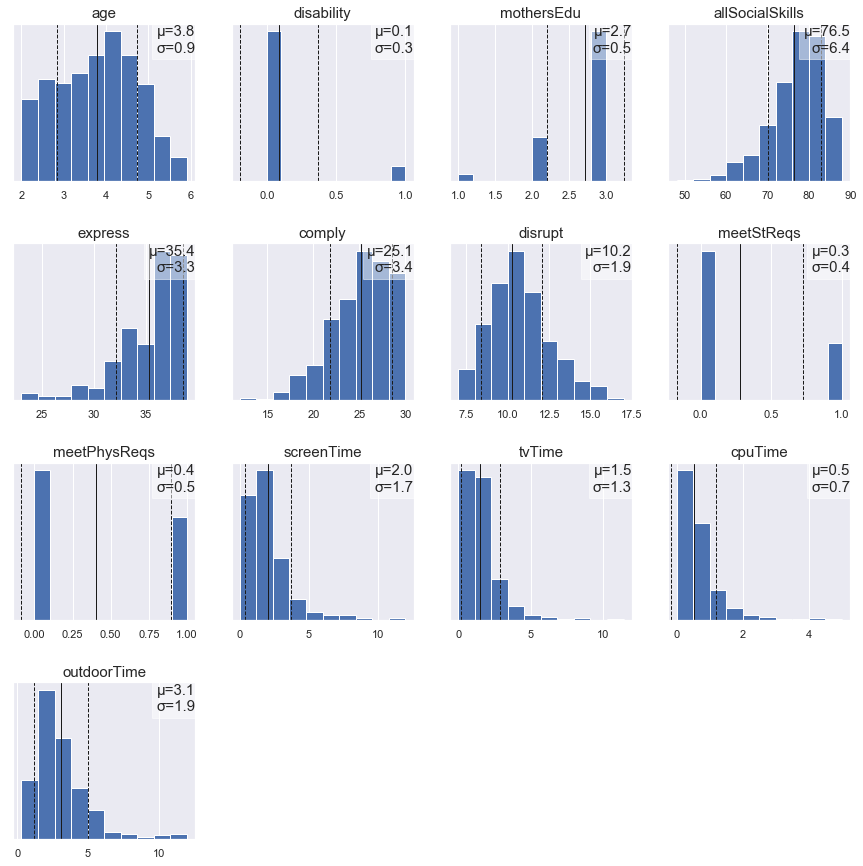

In [69]:
f = plt.figure(figsize=[15,15])
for j,x in enumerate(df.columns[2:]):
    ax = f.add_subplot(4,4,j+1)
    plt.hist(df[x])
    plt.axvline(df[x].mean(), color='k', linestyle='solid', linewidth=1)
    plt.axvline(df[x].mean() - df[x].std(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(df[x].mean() + df[x].std(), color='k', linestyle='dashed', linewidth=1)
    plt.yticks([])
    title = "μ="+str(round(df[x].mean(),1))+"\nσ="+str(round(df[x].std(),1))
    plt.text(1,.8,title,horizontalalignment='right',verticalalignment='bottom', 
             transform=ax.transAxes,bbox={'facecolor':'white', 'alpha': .5})
    plt.title(x, fontsize=15)
plt.subplots_adjust(hspace=.4)
plt.show()

Note that "allSocialSkills" is a calculated field that incorporates "express", "comply", and "disrupt". See [here](https://journals.sagepub.com/doi/10.1177/073428299201000303) for more information on the ASBI. 

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 1080x1080 with 0 Axes>

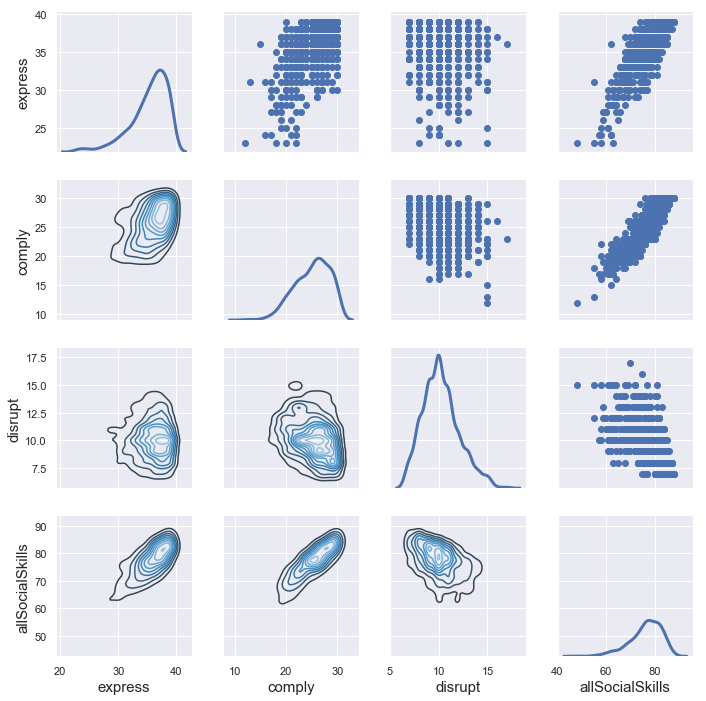

In [70]:
sns.set({'axes.titlesize':15., 'axes.labelsize':15., 'xtick.labelsize': 11.0,
         'ytick.labelsize': 11.0,'legend.fontsize': 11.0})
g = sns.PairGrid(df[['express', 'comply', 'disrupt', 'allSocialSkills']])
g = g.map_upper(plt.scatter)
g = g.map_lower(sns.kdeplot, cmap="Blues_d")
g = g.map_diag(sns.kdeplot, lw=3, legend=False)
plt.show()